# Project: Identify Customer Segments

In this project, we will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that we will use has been provided by Bertelsmann Arvato Analytics.

In [1]:
# import libraries here;
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# magic word for producing visualizations in notebook
%matplotlib inline


'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There were four types of data files associated with this project and were not included in the repository due to privacy:

- `AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. We will use this information to cluster the general population into groups with similar demographic properties. Then, we will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so we need an additional argument in our [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.


In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
feat_info.head()


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. We used this file to help make cleaning decisions during this stage of the project. First of all, we assessed the demographics data in terms of missing data. 

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. We did a little bit of parsing to make use of it to identify and clean the data. We converted the data that matched a 'missing' or 'unknown' value code into a numpy NaN value. We also looked how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

In [5]:
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: str(x).strip('[]').split(',')).apply(lambda x: str(x).strip('[]').split(','))


In [6]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"['-1', '0']"
1,ALTERSKATEGORIE_GROB,person,ordinal,"['-1', '0', '9']"
2,ANREDE_KZ,person,categorical,"['-1', '0']"
3,CJT_GESAMTTYP,person,categorical,['0']
4,FINANZ_MINIMALIST,person,ordinal,['-1']


In [7]:
feat_info.missing_or_unknown

0           ['-1',  '0']
1     ['-1',  '0',  '9']
2           ['-1',  '0']
3                  ['0']
4                 ['-1']
5                 ['-1']
6                 ['-1']
7                 ['-1']
8                 ['-1']
9                 ['-1']
10                ['-1']
11                 ['0']
12                  ['']
13                  ['']
14          ['-1',  '0']
15                 ['0']
16                 ['0']
17                 ['0']
18                 ['0']
19                 ['0']
20                 ['0']
21          ['-1',  '0']
22          ['-1',  '0']
23                 ['0']
24          ['-1',  '9']
25          ['-1',  '9']
26          ['-1',  '9']
27          ['-1',  '9']
28          ['-1',  '9']
29          ['-1',  '9']
             ...        
55                ['-1']
56                ['-1']
57          ['-1',  'X']
58                ['XX']
59         ['-1',  'XX']
60                ['-1']
61                ['-1']
62                ['-1']
63                ['-1']


Some columns have XX and X values for unknowns

In [8]:
feat_info.loc[57:59]

,attribute,information_level,type,missing_or_unknown
57,CAMEO_DEUG_2015,microcell_rr4,categorical,"['-1', 'X']"
58,CAMEO_DEU_2015,microcell_rr4,categorical,['XX']
59,CAMEO_INTL_2015,microcell_rr4,mixed,"['-1', 'XX']"


In [9]:
azdias['CAMEO_INTL_2015'].unique()

array([nan, '51', '24', '12', '43', '54', '22', '14', '13', '15', '33',
       '41', '34', '55', '25', '23', '31', '52', '35', '45', '44', '32',
       'XX'], dtype=object)

In [10]:
azdias['CAMEO_DEU_2015'].unique()

array([nan, '8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D',
       '5C', '8B', '7A', '5D', '9E', '9B', '1B', '3D', '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C', 'XX'], dtype=object)

Making all unknown values of the same format to be converted later to NaNs

In [11]:
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].replace('XX',-1)
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].replace('X',-1)
azdias['CAMEO_DEU_2015'] = azdias['CAMEO_DEU_2015'].replace('XX',-1)

In [12]:
azdias['CAMEO_DEU_2015'].unique()

array([nan, '8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D',
       '5C', '8B', '7A', '5D', '9E', '9B', '1B', '3D', '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C', -1], dtype=object)

In [13]:
for i in feat_info.index:
    for j in range(len(feat_info.loc[i,'missing_or_unknown'])):
        try:
            feat_info.loc[i,'missing_or_unknown'][j] = int(feat_info.loc[i,'missing_or_unknown'][j].strip("'").replace("'",'').strip())
        except:
            continue
    azdias.loc[:,(feat_info.loc[i, 'attribute'])].replace(feat_info.loc[i,'missing_or_unknown'], np.nan, inplace=True)
    

In [14]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [15]:
azdias.head(15).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
AGER_TYP,NaN,NaN,NaN,2,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALTERSKATEGORIE_GROB,2,1,3,4,3,1,2,1,3,3,3,2,3,1,3
ANREDE_KZ,1,2,2,2,1,2,2,1,1,2,2,1,1,2,1
CJT_GESAMTTYP,2,5,3,2,5,2,5,3,3,4,1,6,6,5,6
FINANZ_MINIMALIST,3,1,1,4,4,3,1,3,4,2,2,3,5,1,3
FINANZ_SPARER,4,5,4,2,3,1,5,3,4,4,2,4,3,4,4
FINANZ_VORSORGER,3,2,1,5,4,5,1,4,2,2,5,3,4,3,3
FINANZ_ANLEGER,5,5,2,2,1,2,5,1,4,3,3,5,2,5,5
FINANZ_UNAUFFAELLIGER,5,4,3,1,3,2,4,3,2,5,1,5,4,5,5
FINANZ_HAUSBAUER,3,5,5,2,2,5,3,2,2,4,5,3,1,2,3


#### Step 1.1.2: Assess Missing Data in Each Column

There are a few columns that are outliers in terms of the proportion of values that are missing. We used matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identified and documented these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project we just removed them from the dataframe.

For the remaining features, we will look if there are any patterns in which columns have, or share, missing data.

In [16]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
azdias.isnull().sum().sort_values(ascending = False).head(65)

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
                          ...  
ORTSGR_K

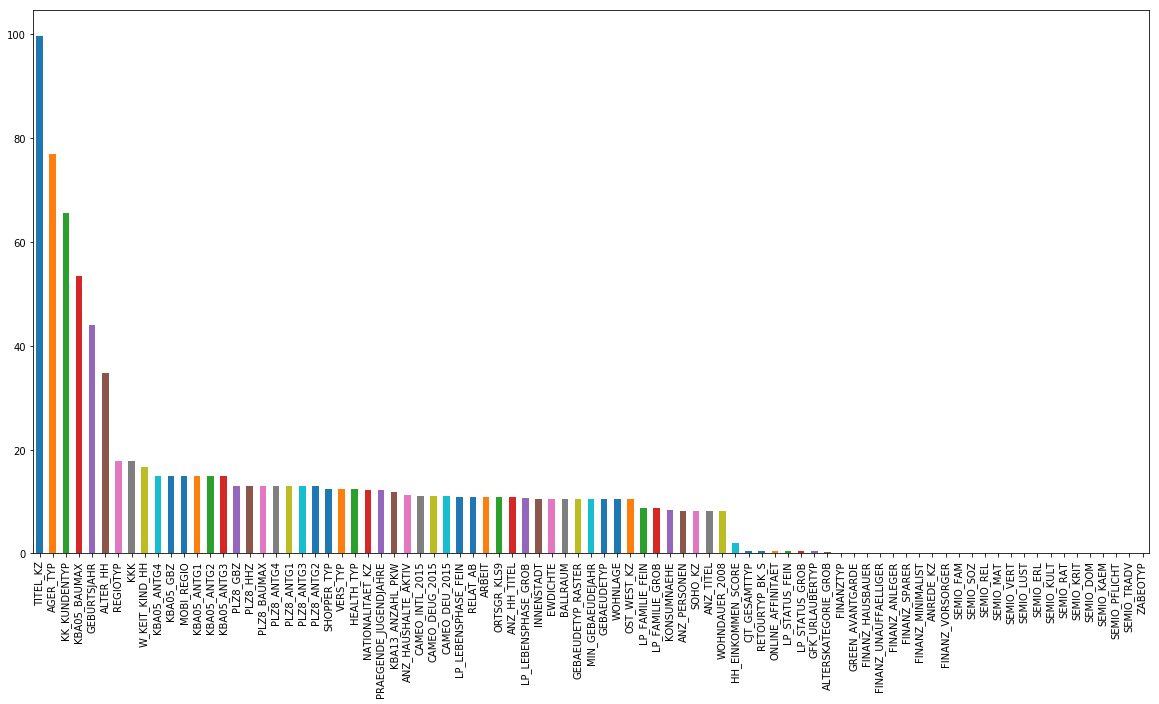

In [17]:
# Investigate patterns in the amount of missing data in each column.
(azdias.isnull().sum()/len(azdias)*100).sort_values(ascending = False).plot.bar(figsize=(20, 10))

In [18]:
# Remove the outlier columns from the dataset. 
bool_indicator = ((azdias.isnull().sum()/len(azdias)*100) > 20) 
drop_cols = bool_indicator[bool_indicator == True].index.tolist()
#columns_to_drop
azdias.drop(drop_cols, axis=1, inplace=True)


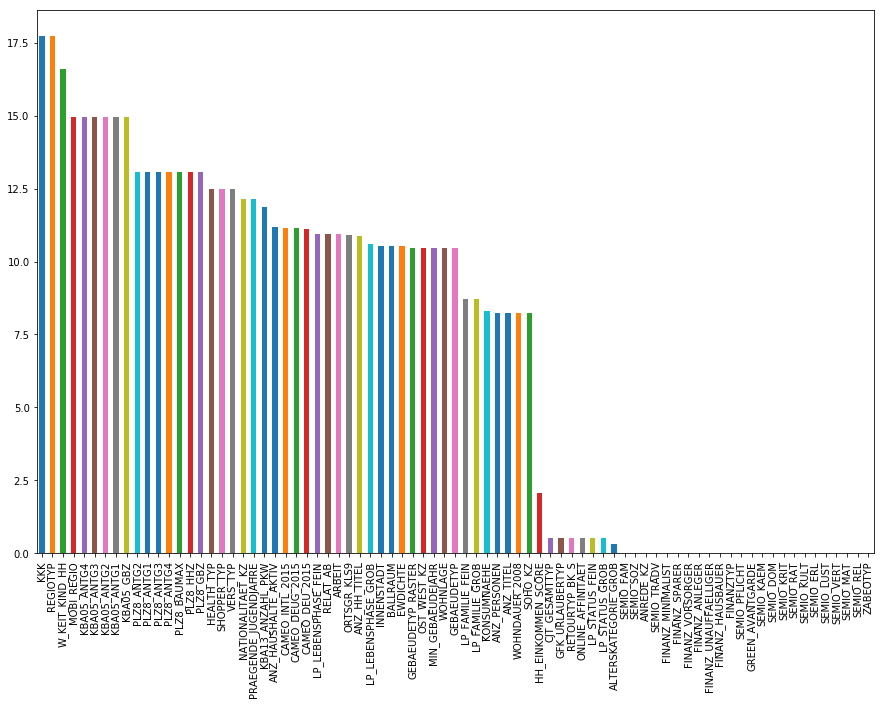

In [19]:
(azdias.isnull().sum()/len(azdias)*100).sort_values(ascending = False).plot.bar(figsize=(15, 10))

#### Discussion 1.1.2: Assess Missing Data in Each Column

The columns with more than 30% of missing data were removed.

In [20]:
drop_cols

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

On average the other columns have less than 18% data missing.

There is a group of 7 columns having less than 2.06 percent of missing data.

The personal information fields are the ones that have the least missing data (< 2%).

Community level fields are the ones that have data missing between 2-11 %.

#### Step 1.1.3: Assess Missing Data in Each Row

Next we performed a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, we saw some group of points that have a very different numbers of missing values. We divided the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. We selected at least five of these columns and compared the distribution of values.

Depending on what we observe in our comparison, this will have implications on how we approach our conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on.

In [21]:
# How much data is missing in each row of the dataset?
missing_row_count = azdias.isnull().sum(axis=1)

In [22]:
missing_row_count.describe()

count    891221.000000
mean          5.649475
std          13.234668
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

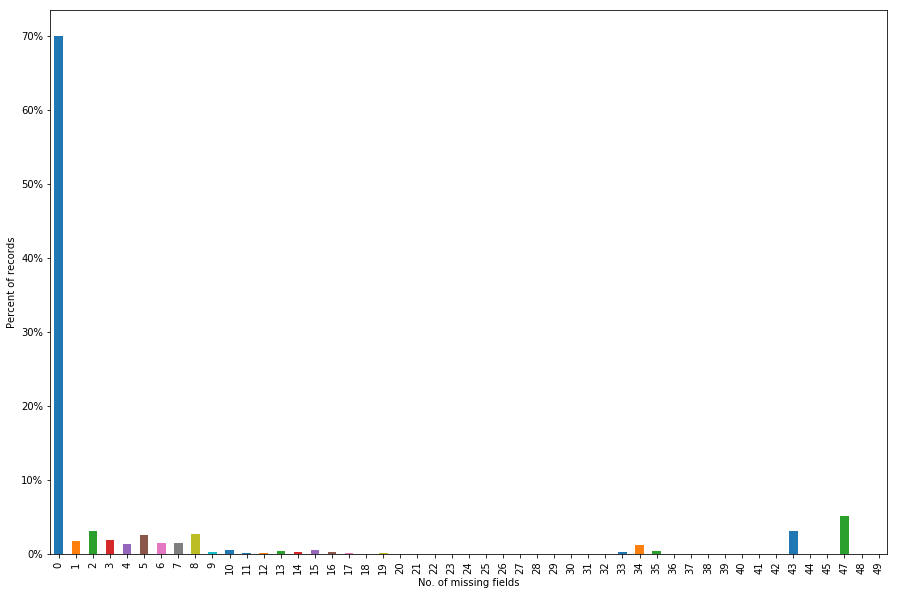

In [23]:
from matplotlib.ticker import PercentFormatter
(missing_row_count.value_counts()/(len(azdias))).sort_index(ascending=True).plot.bar(figsize=(15, 10))
plt.xlabel('No. of missing fields')
plt.ylabel('Percent of records')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

In [24]:
missing_row_count_perc = (missing_row_count/(azdias.shape[1])*100).sort_values(ascending = False)
##Missing data in a row by the total number of columns

In [25]:
missing_row_count_perc.sort_values(ascending=False)

643174    62.025316
732775    62.025316
472919    60.759494
397806    59.493671
344502    59.493671
397698    59.493671
397729    59.493671
397733    59.493671
397770    59.493671
344437    59.493671
397781    59.493671
397784    59.493671
344416    59.493671
397401    59.493671
344632    59.493671
344733    59.493671
398247    59.493671
344734    59.493671
344864    59.493671
397199    59.493671
397202    59.493671
344857    59.493671
397206    59.493671
344578    59.493671
344644    59.493671
344842    59.493671
423507    59.493671
423472    59.493671
423473    59.493671
423479    59.493671
            ...    
683451     0.000000
683455     0.000000
683486     0.000000
683483     0.000000
683120     0.000000
683481     0.000000
683121     0.000000
683122     0.000000
683124     0.000000
683125     0.000000
683127     0.000000
683128     0.000000
683129     0.000000
683130     0.000000
683132     0.000000
683105     0.000000
683043     0.000000
683291     0.000000
683293     0.000000


In [26]:
missing_row_count_perc.describe()

count    891221.000000
mean          7.151235
std          16.752744
min           0.000000
25%           0.000000
50%           0.000000
75%           3.797468
max          62.025316
dtype: float64

In [27]:
# Dividing the data into two subsets based on the number of missing
# values in each row.

len(missing_row_count_perc[missing_row_count_perc >= 5])/len(missing_row_count) * 100

23.194583610574707

23 Percent of the rows have 5% or more data missing and 77% have less than 5% data missing in each row

In [28]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

In [34]:
#Rows with more than 5% data missing
high_missing_rows = azdias.loc[missing_row_count_perc[missing_row_count_perc > 5].index]
high_missing_rows.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
643174,3.0,1,NaN,2,5,3,5,5,2,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
732775,3.0,2,NaN,3,5,3,5,5,2,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
472919,1.0,1,NaN,5,1,5,2,3,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183108,1.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139316,3.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
#Rows with less than 5% data missing
low_missing_rows = azdias.loc[missing_row_count_perc[missing_row_count_perc < 5].index]
low_missing_rows.tail()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
540280,4.0,2,2.0,5,1,5,1,2,3,2,...,2.0,3.0,2.0,0.0,1.0,4.0,4.0,4.0,5.0,3.0
540277,4.0,2,3.0,2,3,3,3,1,3,6,...,1.0,3.0,3.0,2.0,5.0,4.0,2.0,4.0,8.0,5.0
540275,3.0,2,4.0,5,2,4,3,3,1,6,...,4.0,2.0,0.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
540274,4.0,2,6.0,5,1,5,1,1,2,2,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,3.0,7.0,3.0
445610,4.0,2,2.0,5,1,5,2,1,3,2,...,4.0,1.0,0.0,0.0,1.0,4.0,5.0,2.0,1.0,1.0


In [36]:
columns_for_comp = azdias.columns[0:5].tolist()

In [37]:
columns_for_comp

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER']

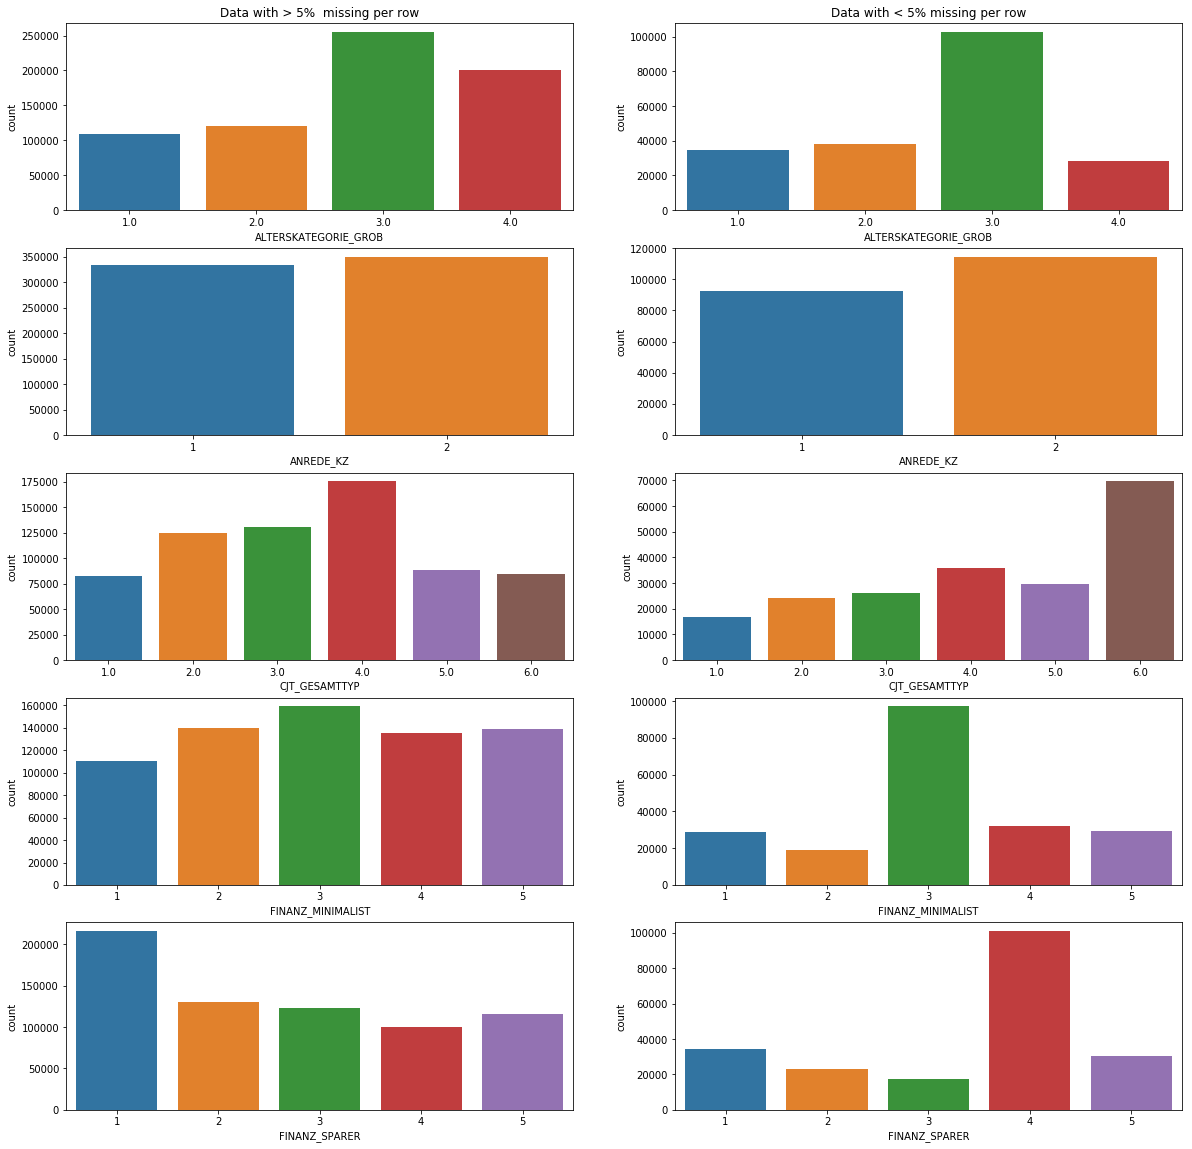

In [38]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20,20))
i=0
axes[0,0].set_title('Data with > 5%  missing per row')
axes[0,1].set_title('Data with < 5% missing per row')
for col in columns_for_comp:
    sns.countplot(low_missing_rows.loc[:, col], ax=axes[i,0])
    
    sns.countplot(high_missing_rows.loc[:, col], ax=axes[i,1])
    
    i+=1

In [39]:
print(azdias.shape[0])
azdias_without_nas = azdias.dropna()
print(azdias_without_nas.shape[0])

891221
623209


In [40]:
azdias_without_nas.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,2.0,2,5.0,1,5,1,5,4,3,4,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0


In [42]:
azdias_without_nas.isnull().sum().sum() #Sanity check

0

#### Discussion 1.1.3: Assess Missing Data in Each Row
Around 70% of the data have no values missing in the rows. Its the 30% that contains the NaNs.

The rows with more than 5% data missing are 23%.

Therefore the 30% of the data with NaNs will be removed to only contain numeric values for the later part of analysis.

Options to manage with missing values:

The graphs were plotted to see the distribution of data with greater and less than 5% of the data missing in the rows.
The findings are that there is minimal variations in the patterns of the two groups. Its hard to say if they differ significantly or not so based on inituition 30% of the rows with missing values will be dropped.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which we can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, we need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, we will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether we keep, drop, or re-encode each. Then, in the last part, we will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once we're done with this step, we'll be ready to get to the machine learning parts of the project!

In [43]:
drop_cols

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [44]:
#Removing columns from feat_info data which were dropped earlier from azdias dataset 
feat_info = feat_info[~feat_info.attribute.isin(drop_cols)]

In [45]:
# How many features are there of each data type?
feat_info.type.value_counts()


ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, we would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, we performed one of the following:
- For binary (two-level) categoricals that take numeric values, we can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, we need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), we can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. 

In [46]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical = feat_info.query("type == 'categorical'").attribute.values
binary = [i for i in categorical if azdias_without_nas[i].nunique()==2]
multi_level = [i for i in categorical if azdias_without_nas[i].nunique()>2]
azdias_without_nas[categorical].nunique()


ANREDE_KZ            2
CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     12
GREEN_AVANTGARDE     2
LP_FAMILIE_FEIN     11
LP_FAMILIE_GROB      5
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
NATIONALITAET_KZ     3
SHOPPER_TYP          4
SOHO_KZ              2
VERS_TYP             2
ZABEOTYP             6
GEBAEUDETYP          4
OST_WEST_KZ          2
CAMEO_DEUG_2015      9
CAMEO_DEU_2015      44
dtype: int64

In [ ]:
##Dropping CAMEO_DEU_2015 from the data as it has 44 unique values which would account for another 44 dummy variables
##Also we have CAMEO_DEUG_2015 as alternative for this one
azdias_without_nas.drop('CAMEO_DEU_2015',axis=1,inplace=True)

In [49]:
multi_level.remove('CAMEO_DEU_2015')

In [50]:
azdias_without_nas[binary].columns.tolist()

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [51]:
# Re-encode categorical variable(s) to be kept in the analysis.

azdias_without_nas['ANREDE_KZ'].replace([2, 1], [1, 0], inplace=True)
azdias_without_nas['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
azdias_without_nas['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Encode the multi level categorical as dummies

In [52]:
azdias_without_nas = pd.get_dummies(azdias_without_nas, columns=multi_level)

In [53]:
azdias_without_nas.shape

(623209, 147)

#### Discussion 1.2.1: Re-Encode Categorical Features

All categorical variables were kept except CAMEO_DEU_2015 as it would increase the amount of columns in the number of dummies created. The binary variables were encoded with 1s and zeros that already did not have the encoding. The remaining were converted into dummy variables

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. 
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, we should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

In [54]:
mixed_vars = feat_info.query("type == 'mixed'")['attribute'].values.tolist()
azdias_without_nas[mixed_vars].nunique()

LP_LEBENSPHASE_FEIN      40
LP_LEBENSPHASE_GROB      12
PRAEGENDE_JUGENDJAHRE    15
WOHNLAGE                  8
CAMEO_INTL_2015          21
PLZ8_BAUMAX               5
dtype: int64

In [55]:
azdias_without_nas.LP_LEBENSPHASE_FEIN.nunique()

40

Dropping LP_LEBENSPHASE_FEIN from the data because of 40 unique values which will be another 40 variables in the dummies.

In [56]:
mixed_vars.remove('LP_LEBENSPHASE_FEIN')

In [57]:
azdias_without_nas.drop('LP_LEBENSPHASE_FEIN',axis=1,inplace=True)

In [58]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
##From the data dictionary file the two categories further mentioned:
mainstream_vals = [1, 3, 5, 8, 10, 12, 14]
avantgarde_vals = [2, 4, 6, 7, 9, 11, 13, 15]

In [59]:
def func_transf(a):
    mainstream_vals = [1, 3, 5, 8, 10, 12, 14]
    avantgarde_vals = [2, 4, 6, 7, 9, 11, 13, 15]
    if a in mainstream_vals:
        return 1
    elif a in avantgarde_vals:
        return 0
    else:
        return x


In [60]:
azdias_without_nas['PRAEGENDE_JUGENDJAHRE_MAIN'] = azdias_without_nas['PRAEGENDE_JUGENDJAHRE'].apply(func_transf)

In [61]:
azdias_without_nas[['PRAEGENDE_JUGENDJAHRE_MAIN','PRAEGENDE_JUGENDJAHRE']].head()

,PRAEGENDE_JUGENDJAHRE_MAIN,PRAEGENDE_JUGENDJAHRE
1,1,14.0
2,0,15.0
4,1,8.0
5,1,3.0
6,1,10.0


In [62]:
x = np.arange(1, 16, 1).tolist()
y = [40, 40, 50, 50, 60, 60, 60, 70, 70, 80, 80, 80, 80, 90, 90]
decade_map = pd.Series(y, index = x)
azdias_without_nas['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias_without_nas['PRAEGENDE_JUGENDJAHRE'].map(decade_map)

In [63]:
azdias_without_nas[['PRAEGENDE_JUGENDJAHRE','PRAEGENDE_JUGENDJAHRE_DECADE']].head()

,PRAEGENDE_JUGENDJAHRE,PRAEGENDE_JUGENDJAHRE_DECADE
1,14.0,90
2,15.0,90
4,8.0,70
5,3.0,50
6,10.0,80


In [64]:
azdias_without_nas.shape

(623209, 148)

In [66]:
azdias_without_nas.CAMEO_INTL_2015.unique()

array(['51', '24', '43', '54', '22', '14', '13', '15', '34', '55', '41',
       '25', '31', '52', '45', '35', '33', '44', '32', '23', '12'], dtype=object)

In [67]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

def wealth(val):
    if ~pd.isnull(val):
        return int(str(val)[0])
        
    else:
        return(np.nan)


def life_stage(val):
    if ~pd.isnull(val):
        return int(str(val)[1])
    else:
        return(np.nan)
    


In [68]:
azdias_without_nas['CAMEO_INTL_2015_WEALTH'] = azdias_without_nas['CAMEO_INTL_2015'].apply(wealth)
azdias_without_nas['CAMEO_INTL_2015_LIFESTAGE'] = azdias_without_nas['CAMEO_INTL_2015'].apply(life_stage)

In [70]:
azdias_without_nas.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_MAIN,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
1,1.0,1,1,5,2,5,4,5,0,3.0,...,0,0,0,0,1,0,1,90,5,1
2,3.0,1,1,4,1,2,3,5,1,3.0,...,1,0,0,0,0,0,0,90,2,4
4,3.0,0,4,3,4,1,3,2,0,3.0,...,0,0,1,0,0,0,1,70,4,3
5,1.0,1,3,1,5,2,2,5,0,3.0,...,0,0,0,0,1,0,1,50,5,4
6,2.0,1,1,5,1,5,4,3,0,2.0,...,1,0,0,0,0,0,1,80,2,2


In [71]:
azdias_without_nas.drop(mixed_vars, axis=1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

A total of 6 mixed-type features existed in the data. Above, 4 new features were engineered which also does not require conversion to dummy variables as they are ordinal in nature. The remaining variables were removed for the simplicity of analysis.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [72]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias_without_nas.shape


(623209, 145)

In [73]:
azdias_without_nas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623209 entries, 1 to 891220
Columns: 145 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_LIFESTAGE
dtypes: float64(37), int64(27), uint8(81)
memory usage: 357.2 MB


### Step 1.3: Create a Cleaning Function

We will need to perform the same cleaning steps on the customer demographics data.

In [74]:
def func_transf(a):
    mainstream_vals = [1, 3, 5, 8, 10, 12, 14]
    avantgarde_vals = [2, 4, 6, 7, 9, 11, 13, 15]
    if a in mainstream_vals:
        return 1
    elif a in avantgarde_vals:
        return 0
    else:
        return x


def wealth(val):
    if ~pd.isnull(val):
        return int(str(val)[0])
        
    else:
        return(np.nan)


def life_stage(val):
    if ~pd.isnull(val):
        return int(str(val)[1])
    else:
        return(np.nan)

In [75]:
def clean_data(df,perc_rem):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame, Criteria for percent of missing data in a column data to be removed
    
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')
    feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: str(x).strip('[]').split(',')).apply(lambda x: str(x).strip('[]').split(','))
    ##Make the format of unknown same
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].replace('XX',-1)
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace('X',-1)
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].replace('XX',-1)
    ##Remove the missing and unknowns
    for i in feat_info.index:
        for j in range(len(feat_info.loc[i,'missing_or_unknown'])):
            try:
                feat_info.loc[i,'missing_or_unknown'][j] = int(feat_info.loc[i,'missing_or_unknown'][j].strip("'").replace("'",'').strip())
            except:
                continue
        df.loc[:,(feat_info.loc[i, 'attribute'])].replace(feat_info.loc[i,'missing_or_unknown'], np.nan, inplace=True)

    # Remove the outlier columns with greater than 20% missing data in the columns from the dataset. 
    bool_indicator = ((df.isnull().sum()/len(df)*100) > perc_rem) 
    drop_cols = bool_indicator[bool_indicator == True].index.tolist()
    #columns_to_drop
    df.drop(drop_cols, axis=1, inplace=True)
    ##Dropping all rows with nans
    df_without_nas = df.dropna()
    feat_info = feat_info[~feat_info.attribute.isin(drop_cols)]
    # Assess categorical variables: which are binary, which are multi-level, and
    # which one needs to be re-encoded?
    categorical = feat_info.query("type == 'categorical'").attribute.values
    binary = [i for i in categorical if df_without_nas[i].nunique()==2]
    multi_level = [j for j in categorical if df_without_nas[j].nunique()>2]
    ##Dropping CAMEO_DEU_2015 from the data as it has 35 unique values which would account for another 35 dummy variables
    ##Also we have CAMEO_DEUG_2015 as alternative for this one
    df_without_nas.drop('CAMEO_DEU_2015',axis=1,inplace=True)
    multi_level.remove('CAMEO_DEU_2015')
    # Re-encode categorical variable(s) to be kept in the analysis.
    df_without_nas['ANREDE_KZ'].replace([2, 1], [1, 0], inplace=True)
    df_without_nas['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
    df_without_nas['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)
    df_without_nas = pd.get_dummies(df_without_nas, columns=multi_level)
    mixed_vars = feat_info.query("type == 'mixed'")['attribute'].values.tolist()
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    ##From the data dictionary file the two categories further mentioned:
   # mainstream_vals = [1, 3, 5, 8, 10, 12, 14]
   # avantgarde_vals = [2, 4, 6, 7, 9, 11, 13, 15]
    df_without_nas['PRAEGENDE_JUGENDJAHRE_MAIN'] = df_without_nas['PRAEGENDE_JUGENDJAHRE'].apply(func_transf)
    x = np.arange(1, 16, 1).tolist()
    y = [40, 40, 50, 50, 60, 60, 60, 70, 70, 80, 80, 80, 80, 90, 90]
    decade_map = pd.Series(y, index = x)
    df_without_nas['PRAEGENDE_JUGENDJAHRE_DECADE'] = df_without_nas['PRAEGENDE_JUGENDJAHRE'].map(decade_map)
    #Investigating CAMEO_INTL_2015 reveals two categories of wealth and lifestage which can be divided by:
    df_without_nas['CAMEO_INTL_2015_WEALTH'] = df_without_nas['CAMEO_INTL_2015'].apply(wealth)
    df_without_nas['CAMEO_INTL_2015_LIFESTAGE'] = df_without_nas['CAMEO_INTL_2015'].apply(life_stage)
    df_without_nas.drop(mixed_vars, axis=1, inplace=True)
    
    return(df_without_nas)

   
    

In [79]:
dem_data = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

In [80]:
clean_df = clean_data(dem_data,30)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [81]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623209 entries, 1 to 891220
Columns: 145 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_LIFESTAGE
dtypes: float64(37), int64(27), uint8(81)
memory usage: 357.2 MB


In [82]:
clean_df.drop('GEBAEUDETYP_5.0',axis=1,inplace=True)

Removing this feature as 5: company building w/o known company is not found in the customers data

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. 


Sanity checking

In [83]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
clean_df.isnull().sum().sum()


0

In [84]:
clean_df.isnull().sum(axis=1).sum()

0

In [85]:
clean_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_MAIN,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
1,1.0,1,1,5,2,5,4,5,0,3.0,...,0,0,0,0,1,0,1,90,5,1
2,3.0,1,1,4,1,2,3,5,1,3.0,...,1,0,0,0,0,0,0,90,2,4
4,3.0,0,4,3,4,1,3,2,0,3.0,...,0,0,1,0,0,0,1,70,4,3
5,1.0,1,3,1,5,2,2,5,0,3.0,...,0,0,0,0,1,0,1,50,5,4
6,2.0,1,1,5,1,5,4,3,0,2.0,...,1,0,0,0,0,0,1,80,2,2


In [86]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
clean_scaled_df = scaler.fit_transform(clean_df)


In [87]:
clean_scaled_df[0:10]

array([[-1.7462911 ,  0.97782476, -1.51222382, ...,  1.16445424,
         1.14788172, -1.25110753],
       [ 0.20210748,  0.97782476, -1.51222382, ...,  1.16445424,
        -0.90999737,  0.74982182],
       [ 0.20210748, -1.02267813,  0.69240603, ..., -0.21339954,
         0.46192202,  0.08284537],
       ..., 
       [ 0.20210748,  0.97782476, -0.7773472 , ...,  1.16445424,
        -1.59595707,  1.41679827],
       [ 0.20210748,  0.97782476, -0.7773472 , ..., -1.59125332,
         1.14788172, -1.25110753],
       [ 0.20210748, -1.02267813,  1.42728265, ..., -0.21339954,
        -0.22403767,  0.74982182]])

### Discussion 2.1: Apply Feature Scaling

Feature scaling is an efficient way of scaling data to be made input to machine learning algorithms.
The features were scaled to a mean of 0 and standard deviation of 1.

### Step 2.2: Perform Dimensionality Reduction

- Using sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, we should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- We will check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Based on what we find, we will select a value for the number of transformed features we'll retain for the clustering part of the project.
- Once we've made a choice for the number of components to keep, we'll re-fit a PCA instance to perform the decided-on transformation.

In [88]:
# Apply PCA to the data.

pca = PCA()
clean_scaled_pca_df = pca.fit_transform(clean_scaled_df)

In [89]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')


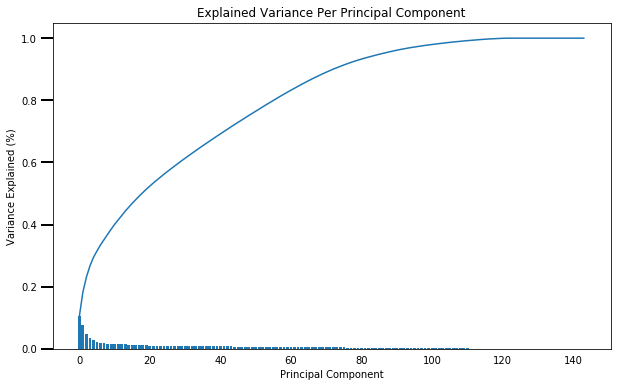

In [90]:
scree_plot(pca)

In [70]:
pca.explained_variance_ratio_[:80].sum() #92% of the variance in the data is explained by the 80 features

0.92949263176758123

In [91]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=80)
azdias_pca_df = pca.fit_transform(clean_scaled_df)


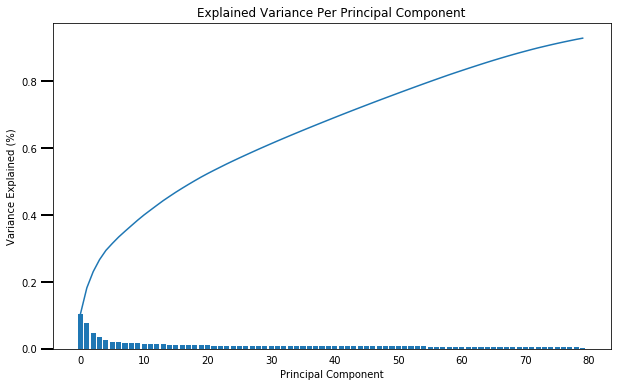

In [92]:
scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

The use of PCA would reduce the number of features from 145 to 80 and still capturing 92% variability in the data.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, we mapped each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. We used the dictionary document to help understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- We investigated and interpreted feature associations from the first three principal components in this substep. To help facilitate this, we wrote a function that could be called at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when we interpret the tendencies of the discovered clusters.

In [95]:
azdias_pca_df.shape

(623209, 80)

Reduced the total features to 80 from 145

In [108]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

def pca_results(full_dataset, pca,n,feats):
    '''
    See the 10 most weighted features from positive and negative sides
    INPUT: dataset, pca, component number (n), and no. of features to map (feats)
    OUTPUT: Dataframe with features mapped on weights
    '''
    map_pca = pd.DataFrame(np.round(pca.components_, 3), columns=full_dataset.keys()).iloc[n - 1]
    map_pca.sort_values(ascending=False, inplace=True)
    map_pca = pd.concat([map_pca.head(feats), map_pca.tail(feats)])                        

    return map_pca
pca_results(clean_df,pca,1,5)

LP_STATUS_GROB_1.0        0.195
HH_EINKOMMEN_SCORE        0.181
CAMEO_INTL_2015_WEALTH    0.175
PLZ8_ANTG3                0.175
PLZ8_ANTG4                0.170
PLZ8_ANTG1               -0.177
KBA05_GBZ                -0.179
KBA05_ANTG1              -0.190
MOBI_REGIO               -0.202
FINANZ_MINIMALIST        -0.203
Name: 0, dtype: float64

In [105]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_results(clean_df,pca,2,5)

ALTERSKATEGORIE_GROB            0.222
FINANZ_VORSORGER                0.201
ZABEOTYP_3                      0.198
SEMIO_ERL                       0.180
RETOURTYP_BK_S                  0.156
SEMIO_PFLICHT                  -0.202
FINANZ_UNAUFFAELLIGER          -0.204
FINANZ_SPARER                  -0.206
SEMIO_REL                      -0.212
PRAEGENDE_JUGENDJAHRE_DECADE   -0.224
Name: 1, dtype: float64

In [106]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_results(clean_df,pca,3,5)

SEMIO_VERT     0.321
SEMIO_FAM      0.259
SEMIO_SOZ      0.256
SEMIO_KULT     0.245
FINANZTYP_5    0.139
SEMIO_ERL     -0.199
SEMIO_KRIT    -0.260
SEMIO_DOM     -0.282
SEMIO_KAEM    -0.314
ANREDE_KZ     -0.344
Name: 2, dtype: float64

### Discussion 2.3: Interpret Principal Components

Positive:

LP_STATUS_GROB_1.0  -> Social status: Villagers      

HH_EINKOMMEN_SCORE  -> Estimated household net income

CAMEO_INTL_2015_WEALTH  -> Wealth status  

PLZ8_ANTG3 -> Number of 6-10 Family houses               

PLZ8_ANTG4 ->  Number of 10+ family houses in the PLZ8 region                            

Negative:

PLZ8_GBZ -> Number of buildings within the PLZ8 region                

PLZ8_ANTG1 -> Number of 1-2 family houses in the PLZ8 region               

KBA05_GBZ  -> Number of buildings in the microcell               

KBA05_ANTG1 -> Number of 1-2 family houses in the microcell             

MOBI_REGIO -> Movement patterns         


Looking in detail at the first PC, the positive features show the social status, household income, wealth and family houses. They are showing strong link towards the wealth household and social status.

The negative side represents the neighbourhood type in terms of no. of buildings, household types and movement patterns.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

We've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. We will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

In [109]:
#Creating a shorter (30% or original) sample df for working 
azdias_samplepca = azdias_pca_df[np.random.choice(len(azdias_pca_df), int(len(azdias_pca_df)*0.30), replace=False)]


In [77]:
sse_score = [] # Sum of Squared Errors
n_clust = np.arange(10, 31,2)

for k in n_clust:
    kmeans = KMeans(k).fit(azdias_samplepca)
    score = np.abs(kmeans.score(azdias_samplepca))
    sse_score.append(score)
    print('No of Clusters: {} k, Score: {}'.format(k, score))

No of Clusters: 10 k, Score: 19007456.09775771
No of Clusters: 12 k, Score: 18603376.393120937
No of Clusters: 14 k, Score: 18240254.543882847
No of Clusters: 16 k, Score: 17955562.960228857
No of Clusters: 18 k, Score: 17642708.56407982
No of Clusters: 20 k, Score: 17290464.260648698
No of Clusters: 22 k, Score: 17119032.780668017
No of Clusters: 24 k, Score: 16810433.094023578
No of Clusters: 26 k, Score: 16658030.144778837
No of Clusters: 28 k, Score: 16467253.77530134
No of Clusters: 30 k, Score: 16365748.36001154


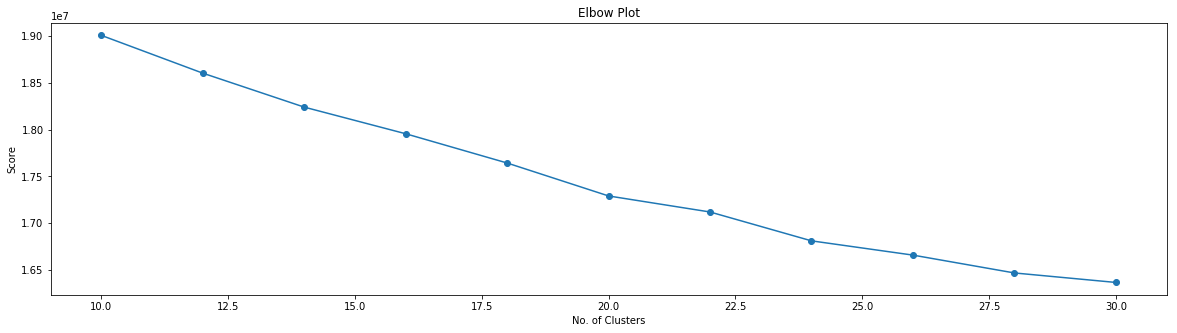

In [78]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.figure(figsize=(20, 5))
plt.xlabel('No. of Clusters')
plt.ylabel('Score')
plt.title('Elbow Plot')
plt.plot(n_clust, sse_score, linestyle='-', marker='o');



In [110]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
k = 20
kmeans = KMeans(k).fit(azdias_pca_df)
clusters_pop = kmeans.predict(azdias_pca_df)

### Discussion 3.1: Apply Clustering to General Population

A shorter version of the data (30%) was selected for randomly applying clustering and determining the Elbow. The plot does show some flattening near the 20 mark so 20 clusters were used as the number of clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that we have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. We are going to use the fits from the general population to clean, transform, and cluster the customer data. 

In [111]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [112]:
customers.shape

(191652, 85)

In [113]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_clean = clean_data(customers,32)


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [114]:
customers_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115643 entries, 0 to 191651
Columns: 144 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_LIFESTAGE
dtypes: float64(37), int64(27), uint8(80)
memory usage: 66.2 MB


In [115]:
customers_clean_scaled = scaler.transform(customers_clean)

In [116]:
cust_pca = pca.transform(customers_clean_scaled)

In [117]:
cust_clust = kmeans.predict(cust_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, we have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. Now we will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Text(0,0.5,'Proportion')

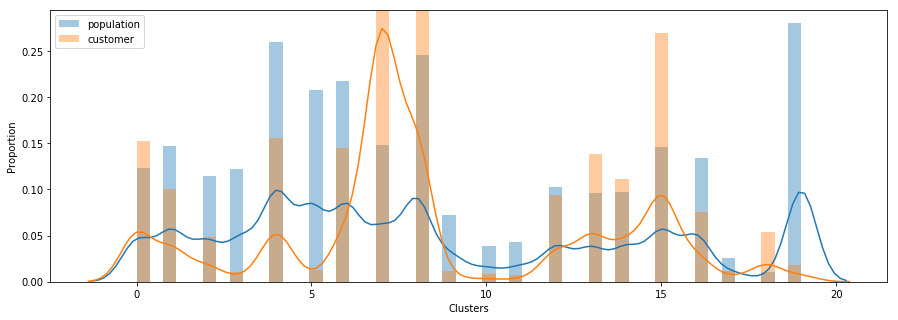

In [118]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
figure = plt.figure()
plt.figure(figsize=(15,5))
sns.distplot(clusters_pop, label='population')
sns.distplot(cust_clust, label='customer')
plt.legend()
plt.xlabel("Clusters")
plt.ylabel("Proportion")

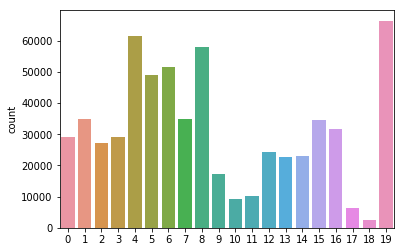

In [119]:
sns.countplot(clusters_pop, label='population')

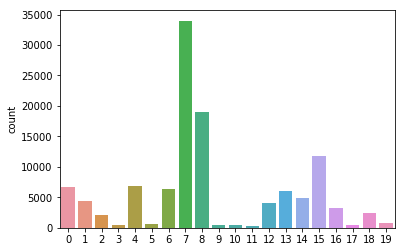

In [120]:
sns.countplot(cust_clust, label='customer')

In [121]:
cust_prop = pd.DataFrame(cust_clust,columns=['Cluster No.']).reset_index().groupby('Cluster No.').count()/(cust_clust.shape[0])*100
pop_prop = pd.DataFrame(clusters_pop,columns=['Cluster No.']).reset_index().groupby('Cluster No.').count()/(clusters_pop.shape[0])*100
diff_prop = (cust_prop-pop_prop)
cust_prop.rename_axis({'index':'Prop_Cust'}, axis=1, inplace=True)
pop_prop.rename_axis({'index':'Prop_Pop'}, axis=1, inplace=True)
diff_prop.rename_axis({'index':'Difference'}, axis=1, inplace=True)
diff_prop = diff_prop.join(cust_prop).join(pop_prop).sort_values('Difference',ascending=False)
diff_prop


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  


,Difference,Prop_Cust,Prop_Pop
Cluster No.,,,
7,23.781160,29.391316,5.610156
8,7.115834,16.441116,9.325283
15,4.678464,10.227165,5.548700
18,1.652157,2.043358,0.391201
13,1.618902,5.261019,3.642117
0,1.119026,5.789369,4.670343
14,0.560866,4.245826,3.684960
12,-0.327927,3.567877,3.895804
17,-0.539619,0.455713,0.995332


In [137]:
# Cluster 7 have people are overrepresented in the
# customer data compared to the general population
clust_7 = kmeans.cluster_centers_[7]
clust_7 = pd.Series(clust_7)
clust_7.sort_values(ascending=False, inplace=True)
clust_7.head(5)

2     3.210631
3     2.279213
10    0.695308
8     0.546262
14    0.497155
dtype: float64

In [138]:
#Converting into original features
clust_7 = scaler.inverse_transform(pca.inverse_transform(clust_7))
clust_7 = pd.Series(clust_7)
clust_7.index = clean_df.columns
clust_7.head()

ALTERSKATEGORIE_GROB    3.067327
ANREDE_KZ               0.479586
FINANZ_MINIMALIST       2.452017
FINANZ_SPARER           2.625169
FINANZ_VORSORGER        3.704001
dtype: float64

Looking at the feature distribution of component 2 for cluster 7

In [141]:
pca_results(customers_clean,pca,2,5)

ALTERSKATEGORIE_GROB            0.222
FINANZ_VORSORGER                0.201
ZABEOTYP_3                      0.198
SEMIO_ERL                       0.180
RETOURTYP_BK_S                  0.156
SEMIO_PFLICHT                  -0.202
FINANZ_UNAUFFAELLIGER          -0.204
FINANZ_SPARER                  -0.206
SEMIO_REL                      -0.212
PRAEGENDE_JUGENDJAHRE_DECADE   -0.224
Name: 1, dtype: float64

In [143]:
# Cluster 19 have people that are underrepresented in the
# customer data compared to the general population
clust_19 = kmeans.cluster_centers_[19]
clust_19 = pd.Series(clust_19)
clust_19.sort_values(ascending=False, inplace=True)
clust_19.head(5)

0     4.956168
3     0.707768
8     0.688461
15    0.486396
9     0.461862
dtype: float64

In [158]:
#Converting into original features
cluster_specs = pd.DataFrame(scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_)), columns=clean_df.columns)
cluster_specs.iloc[19].head()
#Converting into original features
clust_19_feats = cluster_specs.iloc[19]
clust_19_feats.head()

ALTERSKATEGORIE_GROB    1.580555
ANREDE_KZ               1.027020
FINANZ_MINIMALIST       1.073092
FINANZ_SPARER           4.447381
FINANZ_VORSORGER        2.101093
Name: 19, dtype: float64

Looking at the feature distribution of component 0 for cluster 19

In [146]:
pca_results(customers_clean,pca,0,5) ##Looking at the top features for component 0

ANZ_TITEL              0.639
LP_STATUS_FEIN_6.0     0.212
KBA05_ANTG4            0.164
GEBAEUDETYP_RASTER     0.059
SEMIO_MAT              0.059
LP_STATUS_GROB_3.0    -0.096
RETOURTYP_BK_S        -0.100
KONSUMNAEHE           -0.134
ANZ_HAUSHALTE_AKTIV   -0.316
LP_STATUS_FEIN_7.0    -0.558
Name: 79, dtype: float64

In [166]:
clust_7.ZABEOTYP_3

0.43575001785817125

### Discussion 3.3: Compare Customer Data to Demographics Data

Overrepresented categories:


ALTERSKATEGORIE_GROB            Estimated age based on given name analysis: 3: 46 - 60 years old

FINANZ_VORSORGER                Most descriptive financial type for individual : 3: average

ZABEOTYP_3                      Energy consumption typology (Fair type) : 0.44

SEMIO_ERL                       Personality typology, for each dimension: average affinity

RETOURTYP_BK_S                  Return type: conservative 4.5

SEMIO_PFLICHT                   Personality typology, for each dimension: conservative Low-Returner

FINANZ_UNAUFFAELLIGER           Financial typology, for each dimension: high

FINANZ_SPARER                   Financial typology, for each dimension: high - low 

SEMIO_REL                       Personality typology, for each dimension: high - low 

PRAEGENDE_JUGENDJAHRE_DECADE    Generation: 60s


The above describes an age group of 46 - 60 category, average financial type, moderate energy consumption, low returners and generation of 60s to be a good fir for the company.


Underrepresented Categories:

ANZ_TITEL              Birthdate unknown

LP_STATUS_FEIN_6.0     Independent Workers: 0.212

KBA05_ANTG4            no 10+ family homes : 0.5

GEBAEUDETYP_RASTER     mixed cell with middle business share: 3.5

SEMIO_MAT              Personality typology, for each dimension: average affinity - low affinity

LP_STATUS_GROB_3.0     Social status, rough scale - independents (maps to 6-7 in fine scale): 0.006

RETOURTYP_BK_S         Return type : Demanding, heavy 2.2

KONSUMNAEHE            Distance from building to point of sale 250 x 250m 2.2

ANZ_HAUSHALTE_AKTIV    Number of households in the building: 12.2

LP_STATUS_FEIN_7.0     title holder-households :0.004

The above shows independent workers, heavy returners and average personality type to name a few to be not suitable for the company.